# Advanced Lane Finding 

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Step 1: Distortion Correction

Firstly I will use cv2.findChessboardCorners() and cv2.drawChessboardCorners() to find and draw the inside corners in those chessboards.

In [142]:
CAL_IMGS_PATH = 'camera_cal/calibration*.jpg'
TEST_IMGS_PATH = 'test_images/test*.jpg'


class Calibration:
    perspective_src = np.float32([[490, 482],[810, 482],
                                  [1250, 720],[40, 720]])
    perspective_dst = np.float32([[0, 0], [1280, 0], 
                                  [1250, 720],[40, 720]])

    
    def __init__(self, nx, ny):
        # nx represent the number of inside corners in x axis
        # ny represent the number of inside corners in y axis
        self.nx, self.ny = nx, ny
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane
        self.cal_imgs = []
        self.cal_imgs_with_corners = []
        self.test_imgs = []
        self.test_imgs_with_undistorted = []
        self.test_imgs_with_birdseye = []

    def load_cal_imgs(self, cal_path):
        cal_img_names = glob.glob(cal_path)
        self.cal_imgs = [cv2.imread(name) for name in cal_img_names]

    def load_test_imgs(self, test_path):
        test_img_names = glob.glob(test_path)
        self.test_imgs = [cv2.imread(name) for name in test_img_names]

    def draw_corners(self):
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        for img in self.cal_imgs:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            # If found, draw corners
            if ret == True:
                orig_img = img.copy()
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw the corners
                cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                self.cal_imgs_with_corners.append(((orig_img, img)))
   
    def undistort(self):
        for img in self.test_imgs:
            img_size = (img.shape[1], img.shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
            undist = cv2.undistort(img, mtx, dist, None, mtx)
            self.test_imgs_with_undistorted.append((img, undist))
            
    def birds_eye(self):
        for orig_img, undist_img in self.test_imgs_with_undistorted:
            # Grab the image shape
            img_size = (orig_img.shape[1], orig_img.shape[0])
            # Given src and dst points, calculate the perspective transform matrix
            M = cv2.getPerspectiveTransform(self.perspective_src, self.perspective_dst)
            # Warp the image using OpenCV warpPerspective()
            warped = cv2.warpPerspective(undist_img, M, img_size)
            self.test_imgs_with_birdseye.append((orig_img, warped))


    def combined_binary(self):
        combined_binary_lst = []
        for _, img in self.test_imgs_with_birdseye:
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

            b_thresh_min = 155
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
            
            l_thresh_min = 225
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            combined_binary_lst.append(combined_binary)
        
        return combined_binary_lst

    def fill_lane(self):
        combined_binary_lst = self.combined_binary()
        binary_warped = combined_binary_lst[0]

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    def show_cal_plot(self):
        for orig_img, img in self.cal_imgs_with_corners:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(orig_img)
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(img)
            ax2.set_title('Image With Corners', fontsize=18)
            
    def show_test_plot(self):
        for orig_img, img in self.test_imgs_with_undistorted:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Undistorted Image', fontsize=18)
            
    def show_birdseye_plot(self):
        for orig_img, img in self.test_imgs_with_birdseye:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Warped Image', fontsize=18)
            

    def show_threshold_plot(self):
     
        for _, img in self.test_imgs_with_birdseye:
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

#             # Red channel
#             thresh = (200, 255)
#             red = img[:, :, 0]
#             r_channel = np.zeros_like(red)
#             r_channel[(red > thresh[0]) & (red <= thresh[1])] = 1
    
            b_thresh_min = 155
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
            
            l_thresh_min = 225
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            # Plotting thresholded images
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(10,6))
            f.tight_layout()
            
            ax1.set_title('Warped Image', fontsize=16)
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

            ax2.set_title('b binary threshold', fontsize=16)
            ax2.imshow(b_binary, cmap='gray')
            
            ax3.set_title('l binary threshold', fontsize=16)
            ax3.imshow(l_binary, cmap='gray')

            ax4.set_title('Combined color thresholds', fontsize=16)
            ax4.imshow(combined_binary, cmap='gray')

In [143]:
# find and draw the inside corner of the chessboards 
cal = Calibration(9, 6)
cal.load_cal_imgs(CAL_IMGS_PATH)
cal.draw_corners()
# cal.show_cal_plot()

Next I will use undistort() to calculate camera calibration matrix and distortion coefficients. It can remove distortion of image and output the undistorted image.

In [144]:
# undistort the test images
cal.load_test_imgs(TEST_IMGS_PATH)
cal.undistort()
# cal.show_test_plot()


## Step 2: Perspective Transform

In [145]:
cal.birds_eye()
#cal.show_birdseye_plot()

## Step 3: Apply Binary Thresholds

In [146]:
#cal.show_threshold_plot()

## Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

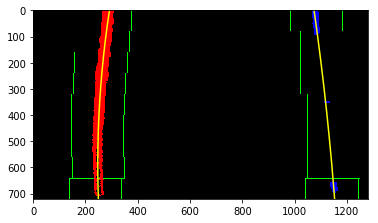

In [147]:
cal.fill_lane()